## exploring clusters created using `cuml`


In [ ]:
!pip install seaborn

In [90]:
%load_ext autoreload
%autoreload 2

import glob

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

import utils


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
# load embeddings matrix using KGEmbeddingStore class
emb_store = utils.load_embedding_store()
X = emb_store.ent_embedding_matrix
dim = X.shape[1]

X.shape

(645565, 800)

In [55]:
# load cluster results. These map each row to a cluster ID.
cluster_files = glob.glob("dbscan_cluster_idxs_*.txt")
cluster_idxs = dict()

for file in cluster_files:
    idxname = file[20:-4]
    with open(file, "r") as f:
        cluster_idxs[idxname] = np.loadtxt(f)
        
    no_clusters = len(np.unique(cluster_idxs[idxname])) - 1
    no_not_clustered = len(np.where(cluster_idxs[idxname] < 1)[0])
    print(f"loaded {idxname} - {no_clusters} clusters - {no_not_clustered} not clustered")

loaded EPS_0.5 - 113 clusters - 645236 not clustered
loaded EPS_0.25 - 26267 clusters - 271287 not clustered


## 1. Cluster size distribution

/Users/kalyan/.pyenv/versions/3.7.9/envs/hcvectors/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/Users/kalyan/.pyenv/versions/3.7.9/envs/hcvectors/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


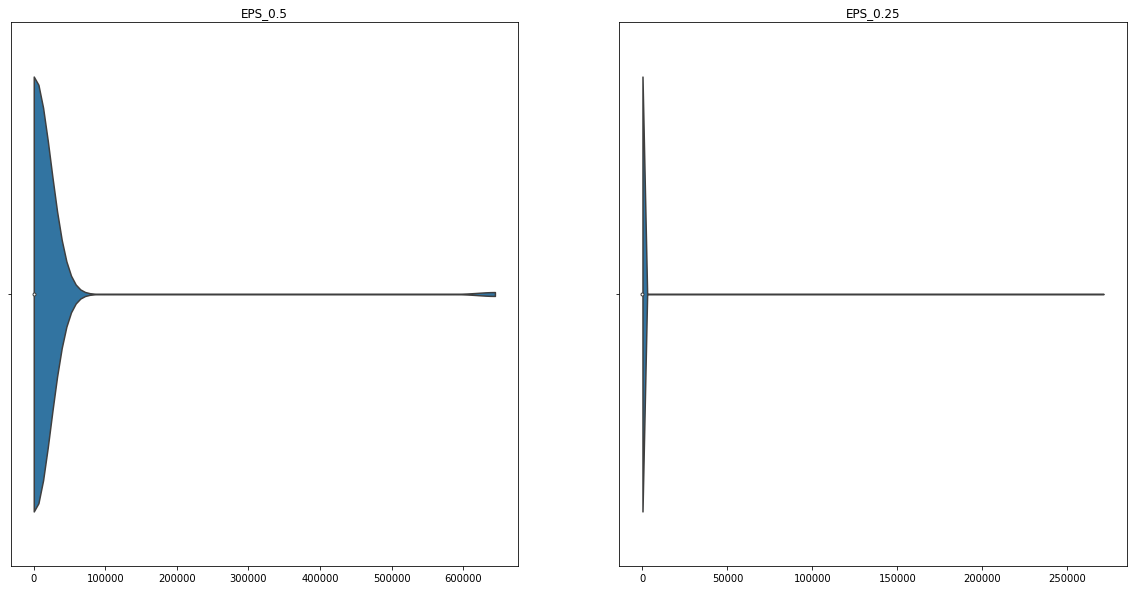

In [85]:
fig, axs = plt.subplots(ncols=len(cluster_files), figsize=(10*len(cluster_files),10))

idx = 0

for k, v in cluster_idxs.items():
    v_clustered = v[np.where(v > 0)]
    unique, counts = np.unique(v, return_counts=True)
    sns.violinplot(counts, ax=axs[idx], cut=0).set_title(k)
    idx+=1

## 2. Viewing individual clusters

In [100]:
def show_cluster(idx, cluster_name):
    cluster_entities = emb_store.idxs_to_entities(
        np.where(cluster_idxs[cluster_name] == idx)
    )

    cluster_urls = [i for i in cluster_entities if i.startswith("http")]
    cluster_label_mapping = utils.get_labels(cluster_urls)
    cluster_labels = [cluster_label_mapping.get(ent, "<no label>") for ent in cluster_entities]
    
    print("\n".join([f"{cluster_labels[i]} - {cluster_entities[i]}" for i in range(len(cluster_entities))]))
    
###
    
idx = 94
cluster_name = "EPS_0.5"    

show_cluster(idx, cluster_name)

<no label> - river avon
<no label> - the portishead dock


## 3. Viewing clusters on the UMAP plot

In [104]:
# load UMAP projections
umap_projection_path = "../../data/processed/final_model_dglke/umap/best_projection_n_neighbours_10.npy"
umap_data = np.load(umap_projection_path)

umap_df = pd.DataFrame(umap_data, columns=["x", "y"])
for k, v in cluster_idxs.items():
    umap_df[k] = v
    umap_df[k] = umap_df[k].astype(int)

umap_df

,x,y,EPS_0.5,EPS_0.25
0,4.982193,4.177696,0,0
1,5.086479,4.084801,0,-1
2,-9.554541,-5.450275,0,1
3,-3.474861,-15.172668,0,2
4,2.950962,4.017635,0,1
...,...,...,...,...
645560,12.588858,7.450304,0,-1
645561,0.775307,-22.604410,0,-1
645562,10.980627,2.249523,0,-1
645563,11.553638,-19.636395,0,-1


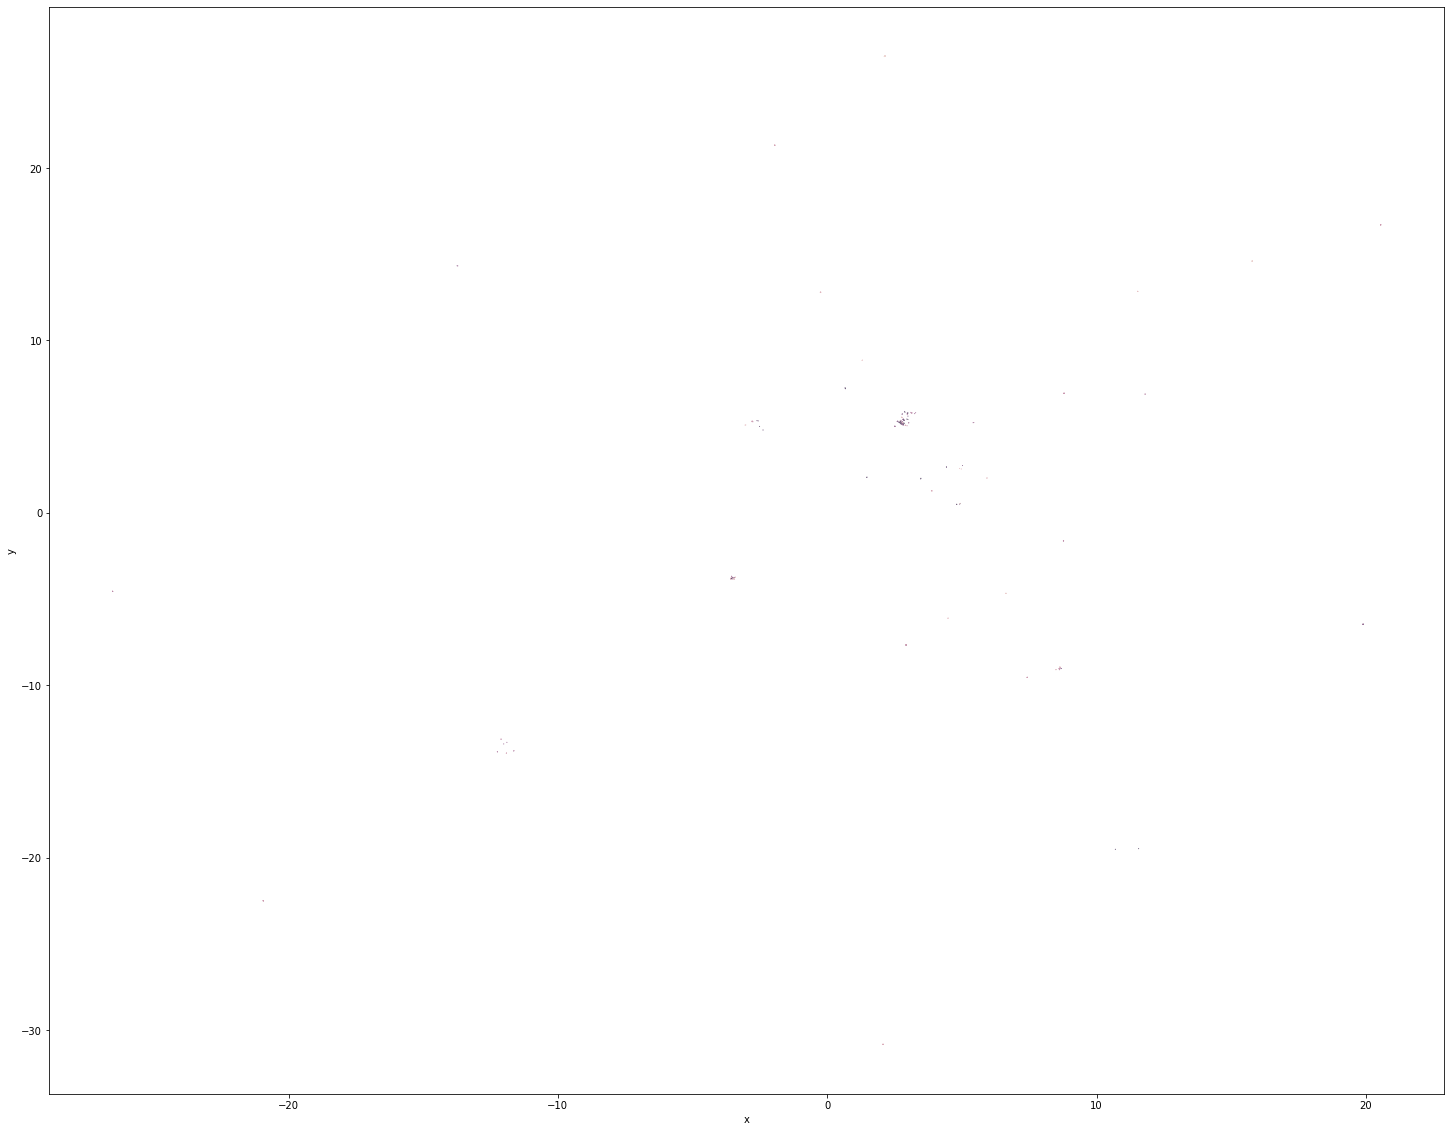

In [110]:
def plot(cluster_name):
    filtered_df = umap_df[umap_df[cluster_name] > 0]
    fig, ax = plt.subplots(figsize=(25,20))
    
    sns.scatterplot(
        x=filtered_df.loc[:, "x"], 
        y=filtered_df.loc[:, "y"], 
        hue=filtered_df[cluster_name], 
        s=1, 
        legend=False,
    )
    
plot("EPS_0.5")
